In [20]:
! pip install kneed

In [35]:
!pip install urbangrammar-graphics

In [36]:
!pip install clustergram

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from kneed import KneeLocator
import sklearn.metrics as metrics
from sklearn.cluster import DBSCAN
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering

In [7]:
# Импортируем датасет
bank_df = pd.read_csv("C:/Users/Даниил/Desktop/ОМО/cc_general.csv")
bank_df.head()


,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [8]:
bank_df.isnull().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

In [9]:
bank_df.dtypes

CUST_ID                              object
BALANCE                             float64
BALANCE_FREQUENCY                   float64
PURCHASES                           float64
ONEOFF_PURCHASES                    float64
INSTALLMENTS_PURCHASES              float64
CASH_ADVANCE                        float64
PURCHASES_FREQUENCY                 float64
ONEOFF_PURCHASES_FREQUENCY          float64
PURCHASES_INSTALLMENTS_FREQUENCY    float64
CASH_ADVANCE_FREQUENCY              float64
CASH_ADVANCE_TRX                      int64
PURCHASES_TRX                         int64
CREDIT_LIMIT                        float64
PAYMENTS                            float64
MINIMUM_PAYMENTS                    float64
PRC_FULL_PAYMENT                    float64
TENURE                                int64
dtype: object

In [10]:
bank_df.nunique()

CUST_ID                             8950
BALANCE                             8871
BALANCE_FREQUENCY                     43
PURCHASES                           6203
ONEOFF_PURCHASES                    4014
INSTALLMENTS_PURCHASES              4452
CASH_ADVANCE                        4323
PURCHASES_FREQUENCY                   47
ONEOFF_PURCHASES_FREQUENCY            47
PURCHASES_INSTALLMENTS_FREQUENCY      47
CASH_ADVANCE_FREQUENCY                54
CASH_ADVANCE_TRX                      65
PURCHASES_TRX                        173
CREDIT_LIMIT                         205
PAYMENTS                            8711
MINIMUM_PAYMENTS                    8636
PRC_FULL_PAYMENT                      47
TENURE                                 7
dtype: int64

### 2. Предобработка данных

In [11]:
# Так как размер датасета 8950 и в нем всего 313 пустых значения, можно избавиться от этих записей
bank_df['MINIMUM_PAYMENTS'].fillna((bank_df['MINIMUM_PAYMENTS'].mean()), inplace = True)
bank_df['CREDIT_LIMIT'].fillna((bank_df['CREDIT_LIMIT'].mean()), inplace = True)
df = bank_df.drop(['CUST_ID'], axis=1)

df.isnull().sum().sort_values(ascending=False)

BALANCE                             0
CASH_ADVANCE_FREQUENCY              0
PRC_FULL_PAYMENT                    0
MINIMUM_PAYMENTS                    0
PAYMENTS                            0
CREDIT_LIMIT                        0
PURCHASES_TRX                       0
CASH_ADVANCE_TRX                    0
PURCHASES_INSTALLMENTS_FREQUENCY    0
BALANCE_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_FREQUENCY                 0
CASH_ADVANCE                        0
INSTALLMENTS_PURCHASES              0
ONEOFF_PURCHASES                    0
PURCHASES                           0
TENURE                              0
dtype: int64

In [12]:
df.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.612411,2895.063757,2330.588021,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,170.857654,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,335.628312,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,864.206542,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


In [13]:
# Составим таблицу корреляции
df.corr().round(2)

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
BALANCE,1.00,0.32,0.18,0.16,0.13,0.50,-0.08,0.07,-0.06,0.45,0.39,0.15,0.53,0.32,0.39,-0.32,0.07
BALANCE_FREQUENCY,0.32,1.00,0.13,0.10,0.12,0.10,0.23,0.20,0.18,0.19,0.14,0.19,0.10,0.07,0.11,-0.10,0.12
PURCHASES,0.18,0.13,1.00,0.92,0.68,-0.05,0.39,0.50,0.32,-0.12,-0.07,0.69,0.36,0.60,0.09,0.18,0.09
ONEOFF_PURCHASES,0.16,0.10,0.92,1.00,0.33,-0.03,0.26,0.52,0.13,-0.08,-0.05,0.55,0.32,0.57,0.05,0.13,0.06
INSTALLMENTS_PURCHASES,0.13,0.12,0.68,0.33,1.00,-0.06,0.44,0.21,0.51,-0.13,-0.07,0.63,0.26,0.38,0.13,0.18,0.09
CASH_ADVANCE,0.50,0.10,-0.05,-0.03,-0.06,1.00,-0.22,-0.09,-0.18,0.63,0.66,-0.08,0.30,0.45,0.14,-0.15,-0.07
PURCHASES_FREQUENCY,-0.08,0.23,0.39,0.26,0.44,-0.22,1.00,0.50,0.86,-0.31,-0.20,0.57,0.12,0.10,0.00,0.31,0.06
ONEOFF_PURCHASES_FREQUENCY,0.07,0.20,0.50,0.52,0.21,-0.09,0.50,1.00,0.14,-0.11,-0.07,0.54,0.30,0.24,-0.03,0.16,0.08
PURCHASES_INSTALLMENTS_FREQUENCY,-0.06,0.18,0.32,0.13,0.51,-0.18,0.86,0.14,1.00,-0.26,-0.17,0.53,0.06,0.09,0.03,0.25,0.07
CASH_ADVANCE_FREQUENCY,0.45,0.19,-0.12,-0.08,-0.13,0.63,-0.31,-0.11,-0.26,1.00,0.80,-0.13,0.13,0.18,0.10,-0.25,-0.13


In [14]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(df)
PCA_names = ['PCA'+str(x) for x in range(1,len(pca.components_)+1)]
pca_data = pd.DataFrame(pca.transform(df), columns=PCA_names)

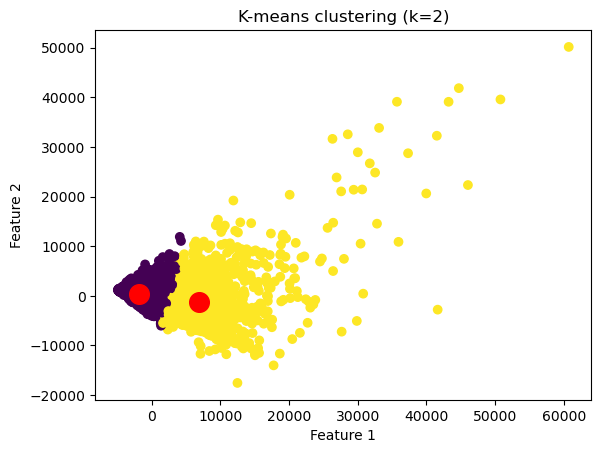

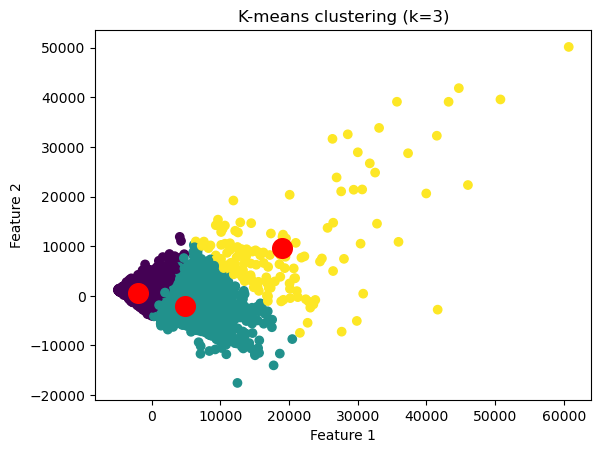

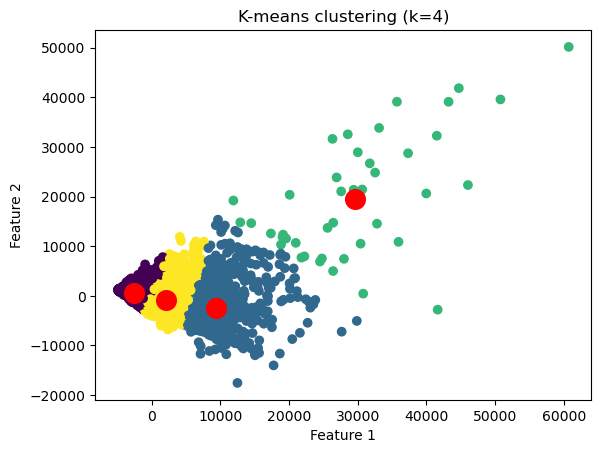

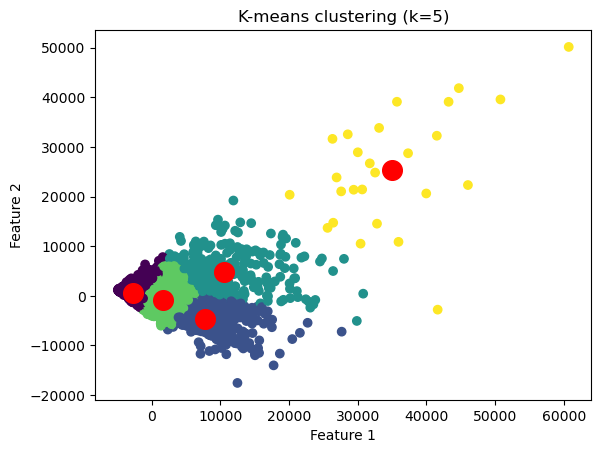

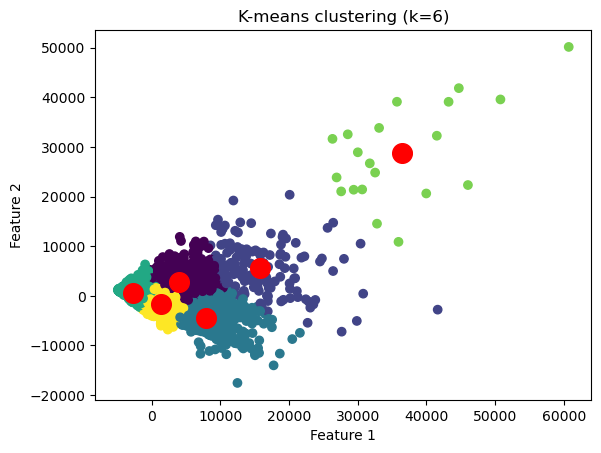

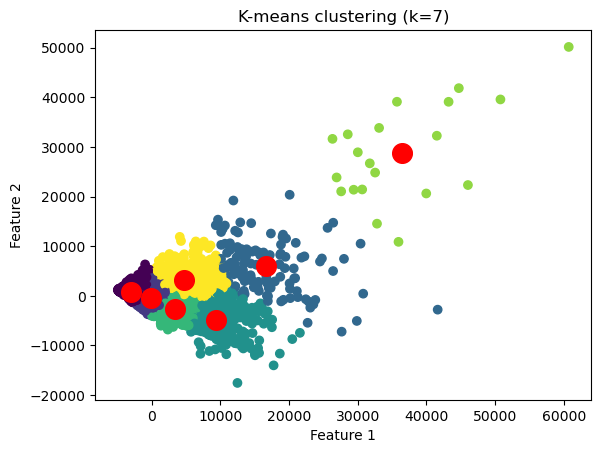

In [15]:
inertia_values = []
k_range = range(2, 8)
for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    y_kmeans = kmeans.fit_predict(pca_data)
    inertia_values.append(kmeans.inertia_)
    plt.scatter(pca_data.iloc[:, 0], pca_data.iloc[:, 1], c=y_kmeans)
    plt.scatter(kmeans.cluster_centers_[:, 0],
                kmeans.cluster_centers_[:, 1],
                s=200, c='red')
    plt.title('K-means clustering (k={})'.format(k))
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

### Для определения оптимального числа кластеров воспользуемся методом локтя (Elbow)

In [17]:
kmeans_constants = {'n_init' : 100, 'random_state' : 1}

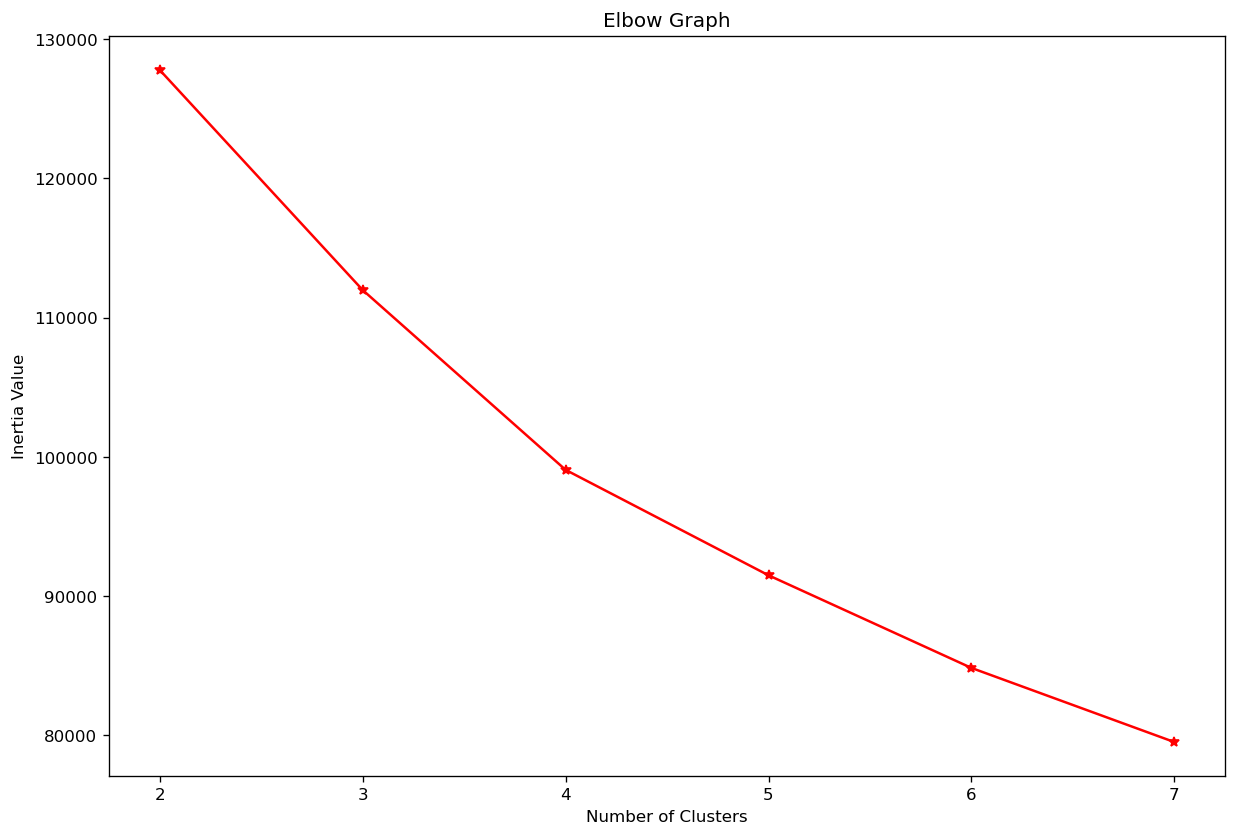

In [33]:
inertia_values = []

for k in range(2, 8):
    scaler = StandardScaler()
    df_normalized = scaler.fit_transform(df)
    model = KMeans(n_clusters = k, **kmeans_constants)
    model.fit(df_normalized)
    inertia_values.append(model.inertia_)

plt.figure(figsize = (12, 8), dpi = 120)
plt.plot(range(2, 8), inertia_values, color = 'r', marker = '*')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia Value')
plt.title('Elbow Graph')
plt.show()

In [34]:
model = KMeans(n_clusters = 5)
model.fit(df_normalized)

print('Inertia : ', model.inertia_)
print('Silhouette Score : ', metrics.silhouette_score(df_normalized, model.labels_))
print('CH Score : ', metrics.calinski_harabasz_score(df_normalized, model.labels_))
print('DB Score : ', metrics.davies_bouldin_score(df_normalized, model.labels_))

Inertia :  91502.59068835489
Silhouette Score :  0.19306474157632153
CH Score :  1482.1806485204172
DB Score :  1.5465131413581676


### **Иерархическая кластеризация** (кластерограмма + k-means)

K=1 skipped. Mean computed from data directly.
K=2 fitted in 73.059 seconds.
K=3 fitted in 72.310 seconds.
K=4 fitted in 71.132 seconds.
K=5 fitted in 71.396 seconds.
K=6 fitted in 76.080 seconds.
K=7 fitted in 78.183 seconds.


Text(0.5, 1.0, 'K-Means (scikit-learn)')

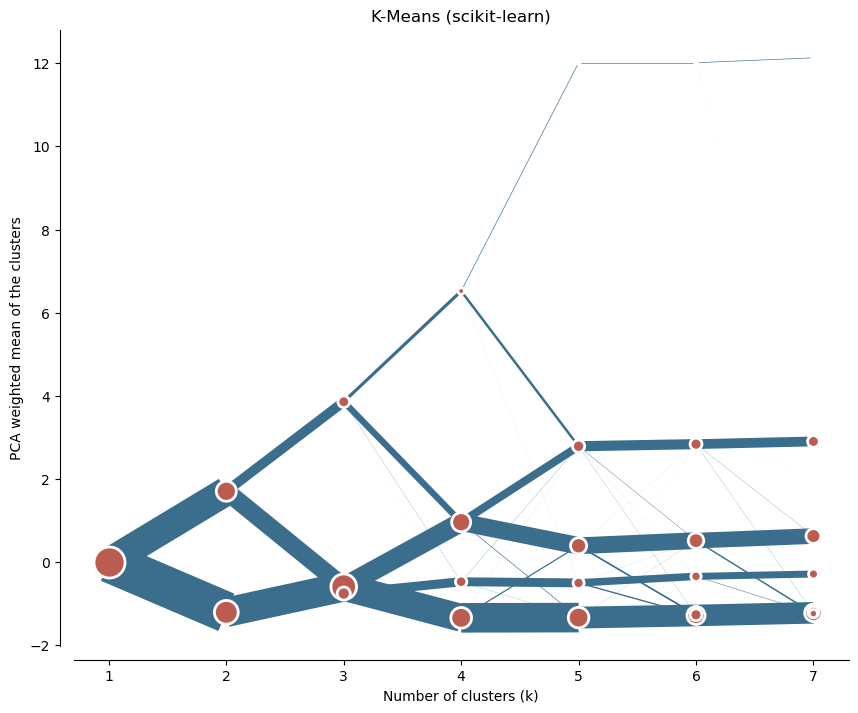

In [37]:
from clustergram import Clustergram
import urbangrammar_graphics as ugg

cgram = Clustergram(range(1, 8), n_init=1000)
cgram.fit(df_normalized)

ax = cgram.plot(
    figsize=(10, 8),
    line_style=dict(color=ugg.COLORS[1]),
    cluster_style={"color": ugg.COLORS[2]},
)
ax.yaxis.grid(False)
sns.despine(offset=10)
ax.set_title('K-Means (scikit-learn)')

### Метод кластеризации на основе плотности DBSCAN

In [70]:
dbscan = DBSCAN(eps=2, min_samples=9)

In [71]:
pca = PCA(n_components=2)
pca_2d = pca.fit_transform(df_normalized)
db = dbscan.fit_predict(df_normalized)

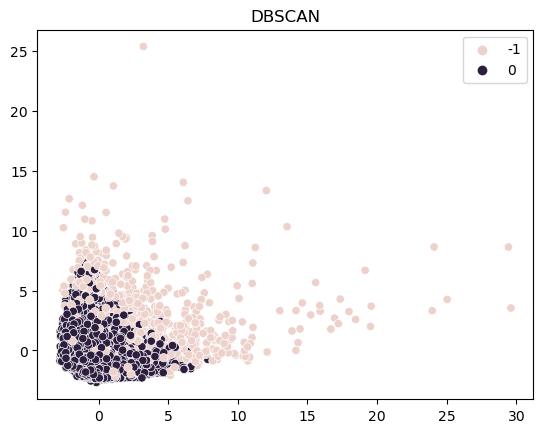

In [72]:
sns.scatterplot(x=pca_2d[:, 0], y=pca_2d[:, 1], hue=db)
plt.title("DBSCAN")
plt.show()

In [74]:
print('Silhouette Score : ', metrics.silhouette_score(pca_2d, dbscan.labels_))
print('CH Score : ', metrics.calinski_harabasz_score(pca_2d, dbscan.labels_))
print('DB Score : ', metrics.davies_bouldin_score(pca_2d, dbscan.labels_))

Silhouette Score :  0.5283316544921598
CH Score :  2206.5046620511584
DB Score :  1.3175095037545677


### Дендрограмма + англомеративная кластеризация

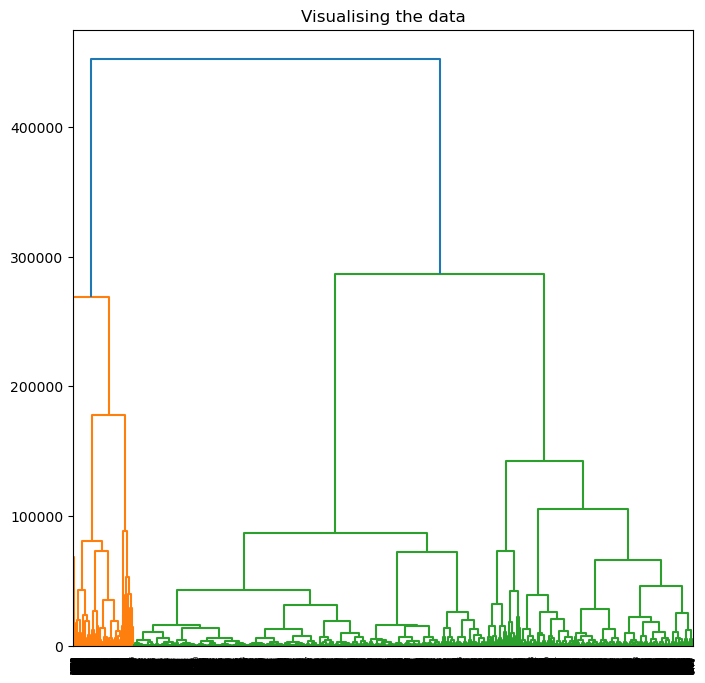

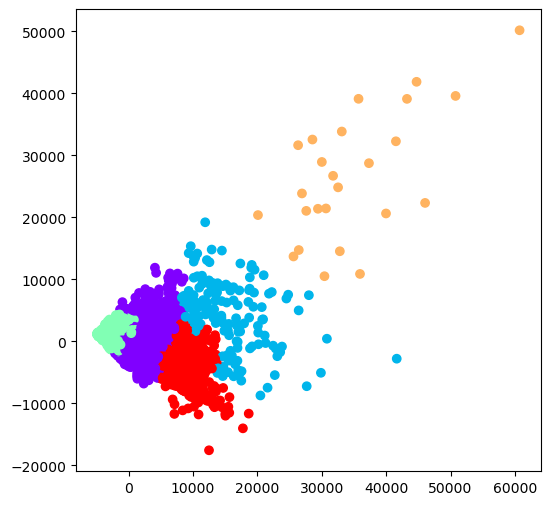

In [55]:
pca = PCA(n_components = 2)
df_normalized2 = pca.fit_transform(df)
X = pd.DataFrame(df_normalized2)
X.columns = ['P1', 'P2']

plt.figure(figsize =(8, 8))
plt.title('Visualising the data')
Dendrogram = shc.dendrogram((shc.linkage(X, method ='ward')))

ac5 = AgglomerativeClustering(n_clusters = 5)
 
plt.figure(figsize =(6, 6))
plt.scatter(X['P1'], X['P2'],
            c = ac5.fit_predict(X), cmap ='rainbow')
plt.show()

In [66]:
print('Silhouette Score : ',silhouette_score(X, ac5.fit_predict(X)))
print('CH Score : ', metrics.calinski_harabasz_score(X, ac5.labels_))
print('DB Score : ', metrics.davies_bouldin_score(X, ac5.labels_))

Silhouette Score :  0.4842060158952302
CH Score :  7096.4613692317935
DB Score :  0.8143206541598061


## Итоги:

In [86]:
silhouette_scores = []
silhouette_scores.append(metrics.silhouette_score(df_normalized, model.labels_))
silhouette_scores.append(metrics.silhouette_score(pca_2d, dbscan.labels_))
silhouette_scores.append(silhouette_score(X, ac5.fit_predict(X)))
                         
CH_scores = []  
CH_scores.append(metrics.calinski_harabasz_score(df_normalized, model.labels_))
CH_scores.append(metrics.calinski_harabasz_score(pca_2d, dbscan.labels_))
CH_scores.append(metrics.calinski_harabasz_score(X, ac5.labels_))
                         
DB_scores = []
DB_scores.append(metrics.davies_bouldin_score(df_normalized, model.labels_))
DB_scores.append(metrics.davies_bouldin_score(pca_2d, dbscan.labels_))
DB_scores.append(metrics.davies_bouldin_score(X, ac5.labels_))                         

**Коэффициент силуэта** - величина, которая позволяет оценить степень соответствия построенной кластерной структуры обучающим данным. Коэффициенты изменяются от -1 до 1. Значения, близкие к 1, указывают на то, что объект является похожим на другие объекты в кластере и не похожим на объекты из других кластеров.

**Calinski–Harabasz** - индекс Калински-Харабаса варьируется от 0 (худшая классификация) до (лучшая классификация).

**Davies_bouldin** - Минимальное значение - 0, чем меньше значение, тем лучше кластеризация

In [83]:
print('1. K-means silhouette score: ', silhouette_scores[0])
print('2. Dbscan silhouette score: ', silhouette_scores[1])
print('3. Anglomerative silhouette score: ', silhouette_scores[2])

1. K-means silhouette score:  0.19306474157632153
2. Dbscan silhouette score:  0.5283316544921598
3. Anglomerative silhouette score:  0.4842060158952302


In [84]:
print('1. K-means calinski harabasz score: ', CH_scores[0])
print('2. Dbscan calinski harabasz score: ', CH_scores[1])
print('3. Anglomerative calinski harabasz score: ', CH_scores[2])

1. K-means calinski harabasz score:  1482.1806485204172
2. Dbscan calinski harabasz score:  2206.5046620511584
3. Anglomerative calinski harabasz score:  7096.4613692317935


In [85]:
print('1. K-means davies bouldin score: ', DB_scores[0])
print('2. Dbscan davies bouldin score:: ', DB_scores[1])
print('3. Anglomerative davies bouldin score:: ', DB_scores[2])

1. K-means davies bouldin score:  1.5465131413581676
2. Dbscan davies bouldin score::  1.3175095037545677
3. Anglomerative davies bouldin score::  0.8143206541598061


**Вывод:** лучший итоговый результат по метрикам показывает англомеративная кластеризация (с N кластеров = 5)